In [2]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

print("HuggingFace Transformers + PyTorch loaded successfully!")


c:\Users\hello\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


HuggingFace Transformers + PyTorch loaded successfully!


In [3]:
!pip install -q transformers datasets accelerate


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Imports
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset, Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [ ]:
df = pd.read_csv('../data/cleaned_labeled_tweets.csv')
df = df[df['label'].isin([0, 1, 2])]
df.head()


,id,final_text,label
0,1601363673259290880,साम्पाङ बालेन गाउँपालिका नगरपालिका वडामा जनप्र...,2.0
1,1601226348013707008,जनप्रतिनिधि सर्वोच्च न्यायाधीश महाभियोग पर्छ।,2.0
2,1601225158538117120,"अत्याचार पास हो, जनप्रतिनिधि झुठो बोलेर पास पद",2.0
3,1601130318731259904,सत्तारुढ गठबन्धनका नेताहरू सरकारमा अख्तियार गर...,2.0
5,1601417900241595904,क्षेत्रमा खराब छैनन खराब राजनीति दल निकट आबद्ध,2.0


In [7]:
# Converting to Hugging Face Dataset
df["label"] = df["label"].astype(int)
dataset = Dataset.from_pandas(df)


# Tokenization
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

def tokenize_fn(batch):
    return tokenizer([str(x) for x in batch["final_text"]], truncation=True, padding=True)

tokenized_ds = dataset.map(tokenize_fn, batched=True)

Map: 100%|██████████| 75826/75826 [00:04<00:00, 15534.40 examples/s]


In [ ]:
# Splitting to Train-Test Split
split_ds = tokenized_ds.train_test_split(test_size=0.2)

In [ ]:
# Defining Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=3)

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to=[],
)

# Defining Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_ds["train"],
    eval_dataset=split_ds["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\hello\AppData\Local\Temp\ipykernel_18252\1517513368.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

predictions = trainer.predict(split_ds["test"])
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Classification Report
print(" Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Neutral", "Positive", "Negative"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Neutral", "Positive", "Negative"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
model_path = "nepali-sentiment-model-xlmr"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)
print(f"Model saved to {model_path}")

✅ Model saved to nepali-sentiment-model-xlmr


In [ ]:
# Defining a Prediction Function for new tweets
from transformers import pipeline

# Loading Pipeline
sentiment_pipeline = pipeline("text-classification", model=model_path, tokenizer=model_path)

label_map = {
    "LABEL_0": "Neutral",
    "LABEL_1": "Positive",
    "LABEL_2": "Negative"
}


def predict_sentiment(text):
    result = sentiment_pipeline(text)[0]
    label = label_map.get(result['label'], result['label'])
    return f" Text: {text}\n Sentiment: {label} (Confidence: {result['score']:.2f})"

Device set to use cuda:0


In [ ]:
print(predict_sentiment("नेपाली जनताको विश्वास गुमाउँदैछन् राजनीतिक दलहरू।"))

📝 Text: नेपाली जनताको विश्वास गुमाउँदैछन् राजनीतिक दलहरू।
🔍 Sentiment: Negative (Confidence: 0.75)


In [ ]:
texts = [
    "प्रधानमन्त्रीको निर्णयले देशको भविष्य उज्यालो बनाउनेछ।",
    "सरकारको भ्रष्टाचारले जनतामा निराशा फैलिएको छ।",
    "चुनावमा सबै उम्मेदवारहरुले जनताको भावना बुझ्नुपर्छ।",
    "नेकपाको घोषणापत्र निकै आशाजनक देखिन्छ।",
    "विपक्षी दलको आरोप निराधार छ भन्ने लाग्दैन।",
    "देश विकास होइन, विनाशतिर गइरहेको जस्तो देखिन्छ।",
    "अहिलेको सरकारले शिक्षा र स्वास्थ्य क्षेत्रमा राम्रो काम गरिरहेको छ।",
    "नेताहरूको भाषण मात्रै हुन्छ, काम शून्य हुन्छ।",
    "आगामी निर्वाचनमा मेरो मत परिवर्तन हुन सक्छ।",
    "नेपाली जनताको विश्वास गुमाउँदैछन् राजनीतिक दलहरू।"
]

for text in texts:
    print(predict_sentiment(text))


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


📝 Text: प्रधानमन्त्रीको निर्णयले देशको भविष्य उज्यालो बनाउनेछ।
🔍 Sentiment: Positive (Confidence: 0.99)
📝 Text: सरकारको भ्रष्टाचारले जनतामा निराशा फैलिएको छ।
🔍 Sentiment: Negative (Confidence: 0.90)
📝 Text: चुनावमा सबै उम्मेदवारहरुले जनताको भावना बुझ्नुपर्छ।
🔍 Sentiment: Positive (Confidence: 0.98)
📝 Text: नेकपाको घोषणापत्र निकै आशाजनक देखिन्छ।
🔍 Sentiment: Positive (Confidence: 0.98)
📝 Text: विपक्षी दलको आरोप निराधार छ भन्ने लाग्दैन।
🔍 Sentiment: Negative (Confidence: 0.87)
📝 Text: देश विकास होइन, विनाशतिर गइरहेको जस्तो देखिन्छ।
🔍 Sentiment: Negative (Confidence: 0.83)
📝 Text: अहिलेको सरकारले शिक्षा र स्वास्थ्य क्षेत्रमा राम्रो काम गरिरहेको छ।
🔍 Sentiment: Positive (Confidence: 0.99)
📝 Text: नेताहरूको भाषण मात्रै हुन्छ, काम शून्य हुन्छ।
🔍 Sentiment: Negative (Confidence: 0.91)
📝 Text: आगामी निर्वाचनमा मेरो मत परिवर्तन हुन सक्छ।
🔍 Sentiment: Positive (Confidence: 0.99)
📝 Text: नेपाली जनताको विश्वास गुमाउँदैछन् राजनीतिक दलहरू।
🔍 Sentiment: Negative (Confidence: 0.75)


# **Error Analysis**

In [ ]:
predictions = trainer.predict(split_ds["test"])
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

In [ ]:
# Attaching Predictions to Original Data
import pandas as pd

df_test = split_ds["test"].to_pandas()
df_test["true_label"] = true_labels
df_test["pred_label"] = pred_labels

In [ ]:
df_test.shape

(15166, 8)

In [ ]:
# Filtering Misclassified Examples
misclassified_df = df_test[df_test["true_label"] != df_test["pred_label"]]
misclassified_df = misclassified_df.reset_index(drop=True)

In [ ]:
# Mapping Label IDs to Sentiment Names
label_map = {0: "Neutral", 1: "Positive", 2: "Negative"}

misclassified_df["true_sentiment"] = misclassified_df["true_label"].map(label_map)
misclassified_df["predicted_sentiment"] = misclassified_df["pred_label"].map(label_map)


In [ ]:
# Insights
print("Total Test Data Shape", df_test.shape)
print("Shape of Misclassified Tweets", misclassified_df.shape)
print("Top Misclassfied Tweets:")
misclassified_df[["final_text", "true_sentiment", "predicted_sentiment"]].head(20)


Total Test Data Shape (15166, 8)
Shape of Misclassified Tweets (3939, 10)
Top Misclassfied Tweets:


,final_text,true_sentiment,predicted_sentiment
0,प्रचण्ड चितवन छोरी हराउने अभिव्यक्ति चुनाब पूर...,Positive,Negative
1,अस्थिरता नाइके प्रचन्डको गठबन्धन बर्ष अडान लिय...,Positive,Negative
2,यै पाराले पुन: भोट,Negative,Positive
3,घाम लगाउने उमेदबार काठमाडौं उपयुक्त भजन जित ।।,Negative,Positive
4,डाक्टर मलेसिया पठाउन,Negative,Positive
5,स्थानिय निर्वाचनमा उम्मेदवारले मत पाए निर्वाचन...,Neutral,Positive
6,खारेज भैसकेको पुरानो नागरिकता उम्मेदवार स्पष्ट...,Positive,Negative
7,"हामि श्रोत चैं तेही थियो, दैनिक चैं",Positive,Negative
8,"भिडन्त हुनुपर्ने नगरपालिका, बर्दियाको रे।",Positive,Negative
9,छैन। रूपमा याे भाषा पढेको छैन। संचार हाे। नेपा...,Positive,Negative


## Confusion Breakdown Per Sentiment

In [ ]:
# Generating Confusion Matrix
from sklearn.metrics import confusion_matrix
import pandas as pd

label_names = ["Neutral", "Positive", "Negative"]
cm = confusion_matrix(true_labels, pred_labels)

cm_df = pd.DataFrame(cm, index=[f"Actual {l}" for l in label_names],
                        columns=[f"Predicted {l}" for l in label_names])

print("Confusion Matrix Breakdown:")
print(cm_df)


Confusion Matrix Breakdown:
                 Predicted Neutral  Predicted Positive  Predicted Negative
Actual Neutral                 466                 312                  96
Actual Positive                 88                7353                1575
Actual Negative                 22                1846                3408


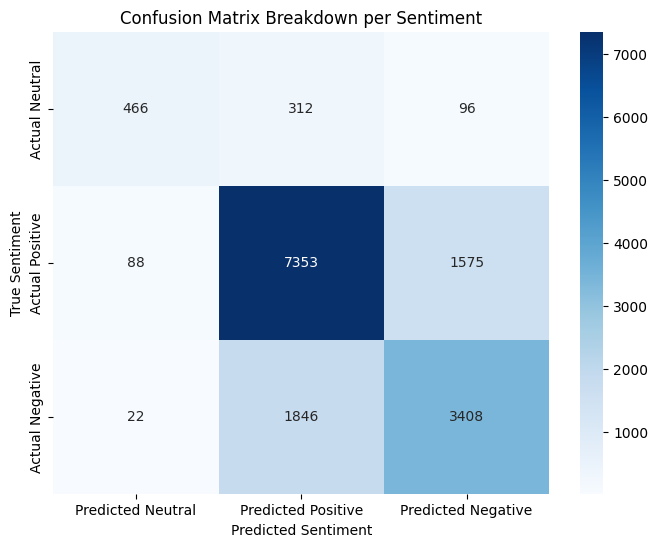

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix Breakdown per Sentiment")
plt.ylabel("True Sentiment")
plt.xlabel("Predicted Sentiment")
plt.show()


### Observation of Error Analysis
Positive sentiment is detected most accurately, with high precision and recall.

Negative sentiment is often misclassified as Positive, suggesting overlapping language or sarcasm in critical tweets.

Neutral tweets are frequently confused with Positive, likely due to subtle or mild language.




## **Pipeline for Real World Tweets**

In [ ]:
import tweepy
import pandas as pd

# Replacing with your own Bearer Token
BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAAO0c3AEAAAAA5K1F00mhGPcO5mHbRTe87xJHBMU%3DyWh4fIbVLFXmBz6jtXBRKzjanpLL3FugcxHo3KuNCnJK7HQCeL"
client = tweepy.Client(bearer_token=BEARER_TOKEN)

query = "(नेपाल OR प्रधानमन्त्री OR राजनीति OR गठबन्धन OR चुनाव OR संसद) lang:ne -is:retweet"

In [ ]:
# Function to fetch nepali Tweets
def fetch_nepali_political_tweets(max_results=50):
    tweets = client.search_recent_tweets(query=query, tweet_fields=["lang", "created_at"], max_results=max_results)
    return [tweet.text for tweet in tweets.data] if tweets.data else []


In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 6.8 MB/s eta 0:00:00


In [ ]:
# Cleaning the Tweets
import re
import emoji

with open("nepali_stopwords.txt", "r", encoding="utf-8") as f:
    stopwords = set(f.read().splitlines())

def clean_tweet(text):
    if pd.isnull(text):
        return ""
    text = emoji.replace_emoji(text, replace="")
    text = re.sub(r"[\u200c\u200d\u200e\u200f\u202a-\u202e]", "", text)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[a-zA-Z0-9०-९।!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~]", "", text)
    text = re.sub(r"[।!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~]", "", text)
    text = re.sub(r"[a-zA-Z0-9०-९]", "", text)
    words = text.strip().split()
    words = [w for w in words if w not in stopwords and 2 <= len(w) <= 20]
    return " ".join(words)

In [ ]:
# Running Predictions Using the Trained Model

from transformers import pipeline

model_path = "nepali-sentiment-model-xlmr"
sentiment_pipeline = pipeline("text-classification",
                              model=model_path,
                              tokenizer=model_path,
                              )

label_map = {
    "LABEL_0": "Neutral",
    "LABEL_1": "Positive",
    "LABEL_2": "Negative"
}

def predict_sentiment(text):
    result = sentiment_pipeline(text)[0]
    label = label_map.get(result['label'], result['label'])
    return label, result['score']


Device set to use cpu


In [ ]:
# Inference and Results

tweets = fetch_nepali_political_tweets(max_results=50)

results = []
for tweet in tweets:
    cleaned = clean_tweet(tweet)
    if cleaned:
        label, score = predict_sentiment(cleaned)
        results.append({
            "text": cleaned,
            "sentiment": label,
            "confidence": round(score, 2)
        })

# Show outcomes
import pandas as pd
df_results = pd.DataFrame(results)
df_results.head(10)

,text,sentiment,confidence
0,सत्ताको हड्डी चुस्न बानि यताका दुईचार अराजक झु...,Negative,0.72
1,"चोर,गोरुचोर जेलभित्र बसेर अपराध काट्दैछ्न् उन्...",Negative,0.81
2,प्रधानमन्त्री भएपछि,Positive,0.69
3,"घिन झाेले, दास चम्चा धर्मबेचुवा काे न्युज ानुभ...",Positive,0.94
4,"दुश्मन? छैन, सिद्धान्तबाट सोचौं: दुश्मन तिमीला...",Negative,0.70
5,पढेलेखेका सिकारि! बनाय भिकारी!,Positive,0.54
6,राजनिति छाेडने भयाे र??,Positive,0.44
7,"नेपाली भाषा, नेपाली राजा, देश, हिन्दू धर्म भने...",Positive,0.75
8,"यिनले क्यार्नु, माईला काकाले उहिल्यै राजनिति ग...",Negative,0.74
9,चुतिया रन्डिको बान नेपालीलाई उल्लु सम्जेको छस ...,Negative,0.72


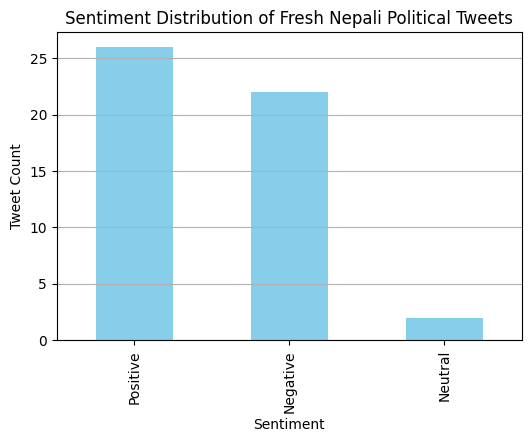

In [ ]:
import matplotlib.pyplot as plt

sentiment_counts = df_results['sentiment'].value_counts()

plt.figure(figsize=(6,4))
sentiment_counts.plot(kind='bar', color='skyblue')
plt.title("Sentiment Distribution of Fresh Nepali Political Tweets")
plt.ylabel("Tweet Count")
plt.xlabel("Sentiment")
plt.grid(axis='y')
plt.show()


# Emotion Detection

In [ ]:
%pip install -q transformers==4.43.3 datasets==2.20.0 evaluate==0.4.2 \
               scikit-learn==1.5.1 accelerate==0.33.0 pandas==2.2.2 \
               numpy==1.26.4 tqdm==4.66.4 deep-translator==1.11.4 matplotlib==3.8.4 torch==2.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/7

In [ ]:
import os, re, json, hashlib, random, pathlib
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

In [ ]:
DATA_PATH = "cleaned_labeled_tweets.csv"
df = pd.read_csv(DATA_PATH)
print(df.shape, list(df.columns))

TEXT_COL = "final_text"
assert TEXT_COL in df.columns, "final_text column not found."

df = df.dropna(subset=[TEXT_COL]).copy()
df = df[df[TEXT_COL].astype(str).str.strip() != ""].reset_index(drop=True)
print("Rows after dropna:", len(df))

URL_RE = re.compile(r"http\S+|www\.\S+")
MENTION_RE = re.compile(r"@\w+")
WS_RE = re.compile(r"\s+")

def basic_clean(s: str) -> str:
    s = URL_RE.sub(" ", str(s))
    s = MENTION_RE.sub(" ", s)
    s = s.replace("\u200d", " ")
    s = WS_RE.sub(" ", s).strip()
    return s

df["text_clean"] = df[TEXT_COL].map(basic_clean)
df.head(3)


(76355, 3) ['id', 'final_text', 'label']
Rows after dropna: 76354


,id,final_text,label,text_clean
0,1601363673259290880,साम्पाङ बालेन गाउँपालिका नगरपालिका वडामा जनप्र...,2.0,साम्पाङ बालेन गाउँपालिका नगरपालिका वडामा जनप्र...
1,1601226348013707008,जनप्रतिनिधि सर्वोच्च न्यायाधीश महाभियोग पर्छ।,2.0,जनप्रतिनिधि सर्वोच्च न्यायाधीश महाभियोग पर्छ।
2,1601225158538117120,"अत्याचार पास हो, जनप्रतिनिधि झुठो बोलेर पास पद",2.0,"अत्याचार पास हो, जनप्रतिनिधि झुठो बोलेर पास पद"


In [ ]:
!pip install -q deep_translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.8 MB/s eta 0:00:00


config.json:   0%|          | 0.00/734 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0
Zero-shot teacher (Nepali): 100%|██████████| 2387/2387 [2:16:13<00:00,  3.42s/it]


emotion
surprise    60744
joy          6112
anger        3932
fear         3222
love         1335
sadness      1009
Name: count, dtype: int64
Avg confidence: 0.5967


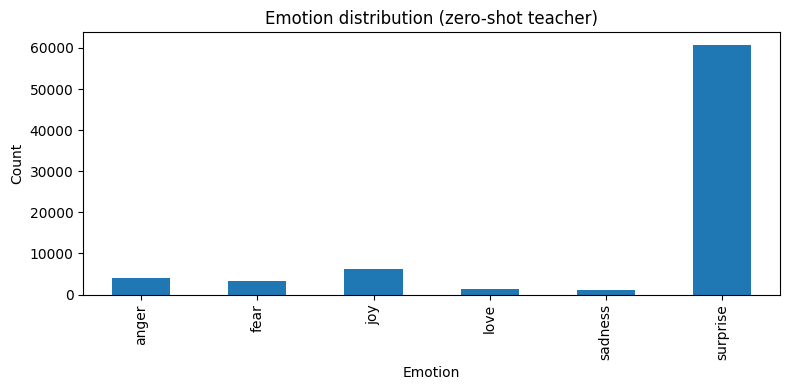

Saved: tweets_emotion_teacher_zs.csv


In [ ]:
from transformers import pipeline
import numpy as np
from tqdm import tqdm
import pandas as pd

assert "text_clean" in df.columns, "Run the minimal cleaning cell first to create df['text_clean']."


SAMPLE_N = None
if SAMPLE_N:
    df_zs = df.sample(n=min(SAMPLE_N, len(df)), random_state=42).copy().reset_index(drop=True)
else:
    df_zs = df.copy().reset_index(drop=True)

EMOTIONS = ["anger","fear","joy","love","sadness","surprise"]

ZSL_MODEL = "joeddav/xlm-roberta-large-xnli"
zs_pipe = pipeline(
    "zero-shot-classification",
    model=ZSL_MODEL,
    device=0 if torch.cuda.is_available() else -1
)

HYPOTHESIS = "यो पाठ {} भावना व्यक्त गर्छ।"

def zs_batch(texts, batch_size=32):
    out = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Zero-shot teacher (Nepali)"):
        batch = texts[i:i+batch_size]
        res = zs_pipe(
            batch,
            candidate_labels=EMOTIONS,
            hypothesis_template=HYPOTHESIS,
            multi_label=False
        )
        if isinstance(res, dict):
            res = [res]
        for r in res:
            labels = [l.lower() for l in r["labels"]]
            scores = r["scores"]
            d = {lab: float(sc) for lab, sc in zip(labels, scores)}
            top = labels[int(np.argmax(scores))]
            d["emotion"] = top
            d["emotion_confidence"] = float(max(scores))
            for e in EMOTIONS:
                d.setdefault(e, 0.0)
            out.append(d)
    return pd.DataFrame(out)

zs_df = zs_batch(df_zs["text_clean"].tolist(), batch_size=32)

if SAMPLE_N:
    df_emo = df.copy()
    df_emo = df_emo.join(
        zs_df.set_index(df_zs.index),
        how="left"
    )
else:
    df_emo = pd.concat([df_zs, zs_df], axis=1)

print(df_emo["emotion"].value_counts(dropna=False))
print("Avg confidence:", round(df_emo["emotion_confidence"].mean(), 4))

ax = (df_emo["emotion"].value_counts()
      .sort_index().plot(kind="bar", figsize=(8,4)))
ax.set_xlabel("Emotion"); ax.set_ylabel("Count"); ax.set_title("Emotion distribution (zero-shot teacher)")
plt.tight_layout(); plt.show()

df_emo.to_csv("tweets_emotion_teacher_zs.csv", index=False)
print("Saved: tweets_emotion_teacher_zs.csv")

In [ ]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter

if "df_emo" not in globals():
    assert os.path.exists("tweets_emotion_teacher_zs.csv"), "Run the zero-shot teacher step first."
    df_emo = pd.read_csv("tweets_emotion_teacher_zs.csv")

EMOTIONS = ["anger","fear","joy","love","sadness","surprise"]

print("Rows:", len(df_emo))
print(df_emo["emotion"].value_counts())
print("Avg confidence:", round(df_emo.get("emotion_confidence", pd.Series()).mean(), 4))

conf_stats = df_emo.groupby("emotion")["emotion_confidence"].describe().loc[EMOTIONS]
conf_stats

Rows: 76354
emotion
surprise    60744
joy          6112
anger        3932
fear         3222
love         1335
sadness      1009
Name: count, dtype: int64
Avg confidence: 0.5967


,count,mean,std,min,25%,50%,75%,max
emotion,,,,,,,,
anger,3932.0,0.425925,0.114957,0.196437,0.339160,0.411268,0.492745,0.929005
fear,3222.0,0.469475,0.122358,0.183923,0.383069,0.456768,0.540451,0.948697
joy,6112.0,0.589623,0.149482,0.190240,0.481798,0.585161,0.701237,0.976237
love,1335.0,0.501568,0.126816,0.205864,0.412698,0.489080,0.579414,0.958017
sadness,1009.0,0.463192,0.122269,0.233123,0.370781,0.442775,0.541871,0.923914
surprise,60744.0,0.619494,0.156193,0.197289,0.505168,0.621485,0.733802,0.990637


In [ ]:
import numpy as np

prob_cols = [c for c in EMOTIONS if c in df_emo.columns]
assert len(prob_cols) == 6, "Expected per-emotion probability columns present from the teacher step."

probs = df_emo[prob_cols].to_numpy(dtype=float)
top = probs.max(axis=1)
sec = np.partition(probs, -2, axis=1)[:, -2]
margin = top - sec

df_emo["top2_margin"] = margin

MIN_CONF = 0.65
MIN_MARGIN = 0.15

df_pl = df_emo[
    (df_emo["emotion_confidence"] >= MIN_CONF) &
    (df_emo["top2_margin"] >= MIN_MARGIN) &
    (df_emo["emotion"].isin(EMOTIONS)) &
    (df_emo["text_clean"].astype(str).str.strip() != "")
].copy()

print("After filtering:", len(df_pl))
print(df_pl["emotion"].value_counts())

After filtering: 29123
emotion
surprise    26280
joy          2149
fear          275
anger         176
love          164
sadness        79
Name: count, dtype: int64


In [ ]:
SEED = 42
CAP_PER_CLASS = 12000  

parts = []
for lab, grp in df_pl.groupby("emotion", sort=False):
    take = min(len(grp), CAP_PER_CLASS)
    parts.append(grp.sample(n=take, random_state=SEED))
df_bal = pd.concat(parts).sample(frac=1.0, random_state=SEED).reset_index(drop=True)

print("Balanced counts:\n", df_bal["emotion"].value_counts().reindex(EMOTIONS).fillna(0).astype(int))


Balanced counts:
 emotion
anger         176
fear          275
joy          2149
love          164
sadness        79
surprise    12000
Name: count, dtype: int64


In [ ]:
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

BASE_MODEL = "xlm-roberta-base"
label2id = {l:i for i,l in enumerate(EMOTIONS)}
id2label = {i:l for l,i in label2id.items()}

df_bal = df_bal.rename(columns={"text_clean":"text"}).assign(label=df_bal["emotion"].map(label2id))

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

def tok(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

train_df, temp_df = train_test_split(df_bal, test_size=0.2, stratify=df_bal["label"], random_state=SEED)
val_df, test_df   = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=SEED)

ds_train = Dataset.from_pandas(train_df[["text","label"]]).map(tok, batched=True).remove_columns(["text"])
ds_val   = Dataset.from_pandas(val_df[["text","label"]]).map(tok, batched=True).remove_columns(["text"])
ds_test  = Dataset.from_pandas(test_df[["text","label"]]).map(tok, batched=True).remove_columns(["text"])

ds_train.set_format(type="torch", columns=["input_ids","attention_mask","label"])
ds_val.set_format(type="torch", columns=["input_ids","attention_mask","label"])
ds_test.set_format(type="torch", columns=["input_ids","attention_mask","label"])

len(ds_train), len(ds_val), len(ds_test)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/11874 [00:00<?, ? examples/s]

Map:   0%|          | 0/1484 [00:00<?, ? examples/s]

Map:   0%|          | 0/1485 [00:00<?, ? examples/s]

(11874, 1484, 1485)

In [ ]:
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

BASE_MODEL = "xlm-roberta-base"
label2id = {l:i for i,l in enumerate(EMOTIONS)}
id2label = {i:l for l,i in label2id.items()}

df_bal = df_bal.rename(columns={"text_clean":"text"}).assign(label=df_bal["emotion"].map(label2id))

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

def tok(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

train_df, temp_df = train_test_split(df_bal, test_size=0.2, stratify=df_bal["label"], random_state=SEED)
val_df, test_df   = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=SEED)

ds_train = Dataset.from_pandas(train_df[["text","label"]]).map(tok, batched=True).remove_columns(["text"])
ds_val   = Dataset.from_pandas(val_df[["text","label"]]).map(tok, batched=True).remove_columns(["text"])
ds_test  = Dataset.from_pandas(test_df[["text","label"]]).map(tok, batched=True).remove_columns(["text"])

ds_train.set_format(type="torch", columns=["input_ids","attention_mask","label"])
ds_val.set_format(type="torch", columns=["input_ids","attention_mask","label"])
ds_test.set_format(type="torch", columns=["input_ids","attention_mask","label"])

len(ds_train), len(ds_val), len(ds_test)

Map:   0%|          | 0/11874 [00:00<?, ? examples/s]

Map:   0%|          | 0/1484 [00:00<?, ? examples/s]

Map:   0%|          | 0/1485 [00:00<?, ? examples/s]

(11874, 1484, 1485)

In [ ]:
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.1 MB/s eta 0:00:00


In [ ]:
import transformers, torch, datasets, evaluate, numpy as np
from packaging.version import parse as V

print("transformers:", transformers.__version__)
print("torch:", torch.__version__)
print("datasets:", datasets.__version__)
print("evaluate:", evaluate.__version__)

transformers: 4.55.0
torch: 2.6.0+cu124
datasets: 4.0.0
evaluate: 0.4.5


Class counts: {'anger': np.int64(141), 'fear': np.int64(220), 'joy': np.int64(1719), 'love': np.int64(131), 'sadness': np.int64(63), 'surprise': np.int64(9600)}
Class weights: [14.03546099  8.99545455  1.15125073 15.10687023 31.41269841  0.20614583]


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Compat] Using legacy TrainingArguments (no evaluation_strategy).


/tmp/ipython-input-3726420820.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,1.725500
200,1.692100
300,1.467900
400,1.352100
500,1.277300
600,1.200400
700,1.056900
800,0.957900
900,0.815700
1000,0.953000


Val: {'eval_loss': 1.1131738424301147, 'eval_accuracy': 0.8645552560646901, 'eval_macro_f1': 0.5386279837388462, 'eval_macro_precision': 0.5991151841068313, 'eval_macro_recall': 0.5980816064582594, 'eval_runtime': 2.7294, 'eval_samples_per_second': 543.702, 'eval_steps_per_second': 8.793, 'epoch': 3.0}
Test: {'eval_loss': 0.6798263192176819, 'eval_accuracy': 0.8868686868686869, 'eval_macro_f1': 0.6376268097242376, 'eval_macro_precision': 0.5901972410424042, 'eval_macro_recall': 0.7646700812107788, 'eval_runtime': 2.5249, 'eval_samples_per_second': 588.138, 'eval_steps_per_second': 9.505, 'epoch': 3.0}


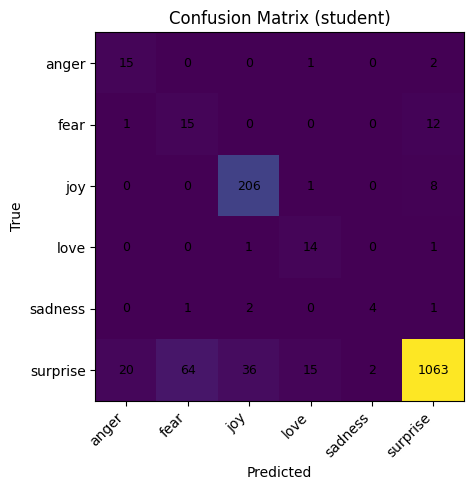

In [ ]:
import torch, numpy as np, evaluate
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import transformers as hf
import torch.nn as nn
from packaging.version import parse as V

train_labels = np.array([int(x["label"].item()) for x in ds_train])
class_counts = np.bincount(train_labels, minlength=len(EMOTIONS)).astype(float)
class_weights = class_counts.sum() / (len(EMOTIONS) * np.maximum(class_counts, 1.0))
class_weights_t = torch.tensor(class_weights, dtype=torch.float)

print("Class counts:", dict(zip(EMOTIONS, class_counts.astype(int))))
print("Class weights:", class_weights)

model = AutoModelForSequenceClassification.from_pretrained(
    BASE_MODEL, num_labels=len(EMOTIONS), id2label=id2label, label2id=label2id
)

metric_acc = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = metric_acc.compute(predictions=preds, references=labels)["accuracy"]
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)
    return {"accuracy": acc, "macro_f1": f1, "macro_precision": p, "macro_recall": r}

class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

common_kwargs = dict(
    output_dir="./runs/nepali_emotion_xlmr",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=100,
    save_steps=400,
    seed=SEED,
    fp16=torch.cuda.is_available(),
    report_to="none",
)

tver = V(hf.__version__)
args = None
try:
    args = TrainingArguments(
        **common_kwargs,
        evaluation_strategy="steps",
        save_strategy="steps",
        eval_steps=400,
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        greater_is_better=True,
        gradient_accumulation_steps=1,
        dataloader_num_workers=2,
    )
except TypeError:
    print("[Compat] Using legacy TrainingArguments (no evaluation_strategy).")
    args = TrainingArguments(
        **common_kwargs,
        gradient_accumulation_steps=1,
        dataloader_num_workers=2,
    )

trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    tokenizer=tokenizer, 
    compute_metrics=compute_metrics,
    class_weights=class_weights_t,
)

trainer.train()

eval_res_val = trainer.evaluate(ds_val)
eval_res_test = trainer.evaluate(ds_test)
print("Val:", eval_res_val)
print("Test:", eval_res_test)

preds = np.argmax(trainer.predict(ds_test).predictions, axis=-1)
true  = np.array([x["label"].item() for x in ds_test])
cm = confusion_matrix(true, preds, labels=range(len(EMOTIONS)))

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm, interpolation='nearest')
ax.set_xticks(range(len(EMOTIONS))); ax.set_yticks(range(len(EMOTIONS)))
ax.set_xticklabels(EMOTIONS, rotation=45, ha="right"); ax.set_yticklabels(EMOTIONS)
ax.set_title("Confusion Matrix (student)"); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=9)
plt.tight_layout(); plt.show()

In [ ]:
import os, json
SAVE_DIR = "nepali-emotion-xlmr"

trainer.save_model(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

with open(os.path.join(SAVE_DIR, "labels.json"), "w", encoding="utf-8") as f:
    json.dump(
        {
            "id2label": {int(k): v for k, v in trainer.model.config.id2label.items()},
            "label2id": trainer.model.config.label2id
        },
        f, ensure_ascii=False, indent=2
    )
print("Saved:", SAVE_DIR)


Saved: nepali-emotion-xlmr


In [ ]:
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

rt_tok  = AutoTokenizer.from_pretrained(SAVE_DIR)
rt_mdl  = AutoModelForSequenceClassification.from_pretrained(SAVE_DIR)
rt_pipe = TextClassificationPipeline(model=rt_mdl, tokenizer=rt_tok,
                                     device=0 if torch.cuda.is_available() else -1,
                                     return_all_scores=True, truncation=True, max_length=128)

def clean_min(s):
    s = re.sub(r"http\S+|www\.\S+"," ", str(s))
    s = re.sub(r"@\w+"," ", s)
    return re.sub(r"\s+"," ", s).strip()

def predict_emotion_nepali(text: str):
    res = rt_pipe([clean_min(text)])[0]
    top = max(res, key=lambda x: x["score"])
    return {"emotion": top["label"], "score": float(top["score"]),
            "probs": {r["label"]: float(r["score"]) for r in res}}

print(predict_emotion_nepali("यो निर्णयप्रति निकै रिस आएको छ।"))

Device set to use cuda:0


{'emotion': 'anger', 'score': 0.8364849090576172, 'probs': {'anger': 0.8364849090576172, 'fear': 0.08398096263408661, 'joy': 0.004838129505515099, 'love': 0.012776857241988182, 'sadness': 0.0328642800450325, 'surprise': 0.029054874554276466}}


/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
import os, re, pandas as pd, torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

SAVE_DIR = "nepali-emotion-xlmr"
assert os.path.exists(SAVE_DIR), f"Model not found at {SAVE_DIR}. Re-check the path."

rt_tok  = AutoTokenizer.from_pretrained(SAVE_DIR)
rt_mdl  = AutoModelForSequenceClassification.from_pretrained(SAVE_DIR)
rt_pipe = TextClassificationPipeline(
    model=rt_mdl,
    tokenizer=rt_tok,
    device=0 if torch.cuda.is_available() else -1,
    return_all_scores=True,
    truncation=True,
    max_length=128
)

def clean_min(s: str):
    s = re.sub(r"http\S+|www\.\S+"," ", str(s))
    s = re.sub(r"@\w+"," ", s)
    return re.sub(r"\s+"," ", s).strip()


Device set to use cuda:0


In [ ]:

TEXT_COL = "final_text"
assert TEXT_COL in df.columns, f"'{TEXT_COL}' not found in df. Available: {list(df.columns)}"

if "text_clean" not in df.columns:
    df = df.copy()
    df["text_clean"] = df[TEXT_COL].fillna("").map(clean_min)

SAMPLE_MODE = "head"
N = 25

if SAMPLE_MODE == "random":
    sample_df = df.sample(n=min(N, len(df)), random_state=42).reset_index(drop=True)
else:
    sample_df = df.head(N).reset_index(drop=True)

from tqdm import tqdm
def batch_predict(texts, batch_size=128):
    out = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Predicting"):
        chunk = [clean_min(t) for t in texts[i:i+batch_size]]
        res_list = rt_pipe(chunk)
        for r in res_list:
            d = {e["label"]: float(e["score"]) for e in r}
            top = max(d, key=d.get)
            d["pred_emotion"] = top
            d["pred_confidence"] = d[top]
            out.append(d)
    return pd.DataFrame(out)

preds = batch_predict(sample_df["text_clean"].tolist(), batch_size=128)

result = pd.concat([sample_df[[ "id", TEXT_COL, "text_clean"]].reset_index(drop=True), preds], axis=1)
display(result.head(10))

out_path = "sample_emotion_predictions.csv"
result.to_csv(out_path, index=False)
print("Saved:", out_path)

Predicting: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


,id,final_text,text_clean,anger,fear,joy,love,sadness,surprise,pred_emotion,pred_confidence
0,1601363673259290880,साम्पाङ बालेन गाउँपालिका नगरपालिका वडामा जनप्र...,साम्पाङ बालेन गाउँपालिका नगरपालिका वडामा जनप्र...,0.051724,0.113309,0.009297,0.009270,0.015114,0.801286,surprise,0.801286
1,1601226348013707008,जनप्रतिनिधि सर्वोच्च न्यायाधीश महाभियोग पर्छ।,जनप्रतिनिधि सर्वोच्च न्यायाधीश महाभियोग पर्छ।,0.749613,0.117504,0.005462,0.007971,0.021989,0.097460,anger,0.749613
2,1601225158538117120,"अत्याचार पास हो, जनप्रतिनिधि झुठो बोलेर पास पद","अत्याचार पास हो, जनप्रतिनिधि झुठो बोलेर पास पद",0.633734,0.214282,0.003902,0.007127,0.030984,0.109971,anger,0.633734
3,1601130318731259904,सत्तारुढ गठबन्धनका नेताहरू सरकारमा अख्तियार गर...,सत्तारुढ गठबन्धनका नेताहरू सरकारमा अख्तियार गर...,0.132182,0.179339,0.005816,0.007487,0.014266,0.660911,surprise,0.660911
4,1601069274998504960,सत्तारुढ भारतीय जनता पार्टीको ऐतिहासिक जित,सत्तारुढ भारतीय जनता पार्टीको ऐतिहासिक जित,0.013356,0.012012,0.830251,0.028951,0.030179,0.085251,joy,0.830251
5,1601417900241595904,क्षेत्रमा खराब छैनन खराब राजनीति दल निकट आबद्ध,क्षेत्रमा खराब छैनन खराब राजनीति दल निकट आबद्ध,0.245052,0.387474,0.006504,0.006266,0.037704,0.317001,fear,0.387474
6,1601416782962565120,मिडियाले महासचिव गौतमले अमुक आडमा चोलेन्द्र मह...,मिडियाले महासचिव गौतमले अमुक आडमा चोलेन्द्र मह...,0.509804,0.266092,0.003604,0.006000,0.019531,0.194968,anger,0.509804
7,1601420926192869120,सरकार,सरकार,0.361641,0.194919,0.009130,0.015475,0.024599,0.394236,surprise,0.394236
8,1601421115930291968,निर्वाचन निर्वाचन शासन व्यवस्था चुनाव उपचार,निर्वाचन निर्वाचन शासन व्यवस्था चुनाव उपचार,0.091049,0.181888,0.009081,0.007481,0.018374,0.692126,surprise,0.692126
9,1601417926438896128,अर्घाखाँचीको नगरपालिका- पुल कार दुर्घटना घाइते,अर्घाखाँचीको नगरपालिका- पुल कार दुर्घटना घाइते,0.185034,0.209457,0.013917,0.015578,0.048531,0.527483,surprise,0.527483


Saved: sample_emotion_predictions.csv
